# 1. Import

In [1]:
import numpy as np
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
import plotly.express as px

In [2]:
train_df = pd.read_csv("train.csv")
county_id_to_name_map = pd.read_json('county_id_to_name_map.json', typ = 'series')

In [3]:
df = train_df.copy()

In [4]:
county_id_to_name_map = county_id_to_name_map.str.capitalize()

In [5]:
RAND = 10
PALETTE = sns.color_palette(cc.glasbey, n_colors=df.county.nunique())

# 2. EDA

## Description
- county - An ID code for the county.
- is_business - Boolean for whether or not the prosumer is a business.
- product_type - ID code with the following mapping of codes to contract types: {0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}.
- target - The consumption or production amount for the relevant segment for the hour. The segments are defined by the county, is_business, and product_type.
- is_consumption - Boolean for whether or not this row's target is consumption or production.
- datetime - The Estonian time in EET (UTC+2) / EEST (UTC+3).
- data_block_id - All rows sharing the same data_block_id will be available at the same forecast time. This is a function of what information is available when forecasts are actually made, at 11 AM each morning. For example, if the forecast weather data_block_id for predictins made on October 31st is 100 then the historic weather data_block_id for October 31st will be 101 as the historic weather data is only actually available the next day.
- row_id - A unique identifier for the row.
- prediction_unit_id - A unique identifier for the county, is_business, and product_type combination. New prediction units can appear or disappear in the test set.

## General

In [6]:
df

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2
...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59
2018349,15,1,1,28.404,1,2023-05-31 23:00:00,637,2018349,59
2018350,15,1,3,0.000,0,2023-05-31 23:00:00,637,2018350,60


In [7]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   county              2018352 non-null  int64  
 1   is_business         2018352 non-null  int64  
 2   product_type        2018352 non-null  int64  
 3   target              2017824 non-null  float64
 4   is_consumption      2018352 non-null  int64  
 5   datetime            2018352 non-null  object 
 6   data_block_id       2018352 non-null  int64  
 7   row_id              2018352 non-null  int64  
 8   prediction_unit_id  2018352 non-null  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 138.6+ MB


In [8]:
df.describe().apply(lambda x: x.apply('{0:.3f}'.format))

,county,is_business,product_type,target,is_consumption,data_block_id,row_id,prediction_unit_id
count,2018352.000,2018352.000,2018352.000,2017824.000,2018352.000,2018352.000,2018352.000,2018352.000
mean,7.297,0.537,1.899,274.856,0.500,321.875,1009175.500,33.045
std,4.781,0.499,1.082,909.502,0.500,182.634,582648.180,19.591
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,3.000,0.000,1.000,0.378,0.000,166.000,504587.750,16.000
50%,7.000,1.000,2.000,31.133,0.500,323.000,1009175.500,33.000
75%,11.000,1.000,3.000,180.206,1.000,479.000,1513763.250,50.000
max,15.000,1.000,3.000,15480.274,1.000,637.000,2018351.000,68.000


In [9]:
df['county'] = df['county'].map(county_id_to_name_map)
df['is_business'] = df['is_business'].map({0: False, 1: True})
df['product_type'] = df['product_type'].map({0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"})
df['is_consumption'] = df['is_consumption'].map({0: False, 1: True})

# cat = ['county','is_business','product_type','is_consumption']
# df[cat] = df[cat].astype('category')

In [10]:
df = df.astype({
#     "county": "category",
#     "is_business": "category",
#     "product_type": "category",
#     "is_consumption": "category",
    "datetime": "datetime64[ns]",})

In [11]:
# df = df.astype({
#     "county": "uint8",
#     "is_business": "bool",
#     "product_type": "uint8",
#     "is_consumption": "bool",
#     "datetime": "datetime64[ns]",})

In [12]:
# df.describe(include="category")

## Missing values and duplicates

In [13]:
df.isna().sum()[df.isna().sum() != 0]

target    528
dtype: int64

In [14]:
df.duplicated().sum()

0

- ##### There are a small amount (528/2018352 < 0.1%) of missing values and no obvious duplicates in the dataframe.

In [15]:
df[df.isna().any(axis=1)].head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
178938,Harjumaa,False,Fixed,NaN,False,2021-10-31 03:00:00,60,178938,0
178939,Harjumaa,False,Fixed,NaN,True,2021-10-31 03:00:00,60,178939,0
178940,Harjumaa,False,General service,NaN,False,2021-10-31 03:00:00,60,178940,1
178941,Harjumaa,False,General service,NaN,True,2021-10-31 03:00:00,60,178941,1
178942,Harjumaa,False,Spot,NaN,False,2021-10-31 03:00:00,60,178942,2


In [16]:
# df[df.isna().any(axis=1)].describe(include='category')

In [17]:
df[df.isna().any(axis=1)].datetime.unique()

<DatetimeArray>
['2021-10-31 03:00:00', '2022-03-27 03:00:00', '2022-10-30 03:00:00',
 '2023-03-26 03:00:00']
Length: 4, dtype: datetime64[ns]

- ##### All missing values correspond to moving clocks back or forward by one hour when changing to winter/summer time.
- ##### All missing values correspond to the start/end hours of DST.

## Target visualisation

In [18]:
# sorted_list = [
#     "county",
#     "is_business",
#     "product_type",
#     "is_consumption",
# ]

In [19]:
# sorted_train = df.sort_values(sorted_list + ['datetime']).copy()

# train_sg = df.sort_values(sorted_list).groupby(sorted_list, observed=True)

# train_sg[['datetime']].apply(lambda x: x.duplicated()).sum()

In [20]:
# ind = df.copy().dropna().set_index('datetime')

In [21]:
# df.plot(x='target',)
# df.target.plot(kind='bar')

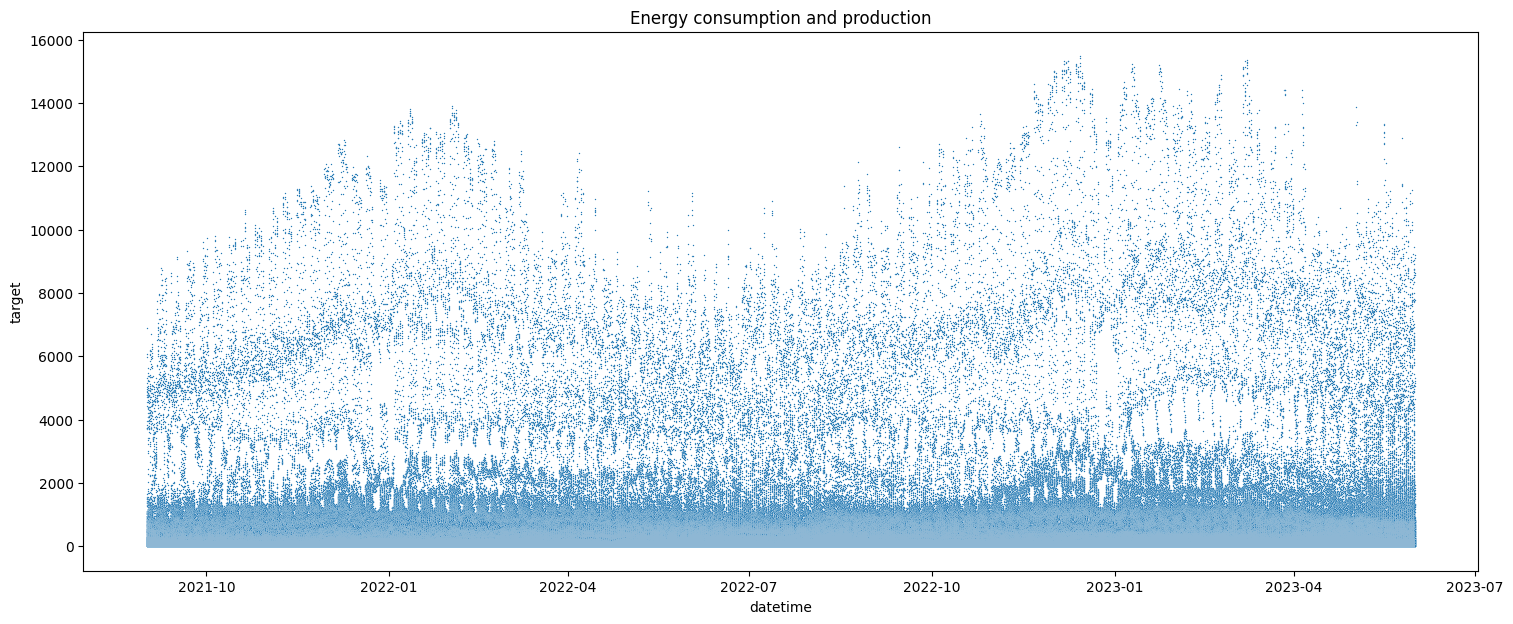

In [22]:
fig, ax = plt.subplots(figsize=(18, 7))
sns.scatterplot(
    data=df,
    x="datetime",
    y="target",
    s=1,)

plt.title(
    "Energy consumption and production")
plt.show()

- ##### Target has seasonal, weekly and less noticeable montly cycles.

In [23]:
# Added negative target values for better visualisation

df["modified_target"] = np.where(
    df["is_consumption"] == 1,
    df["target"] * (-1),
    df["target"],
)

In [24]:
# [[n for n in range(i, i * 10, i)] for i in [1, 10, 100, 1000,]]

In [25]:
# yticks = [[n for n in range(i, i * 10, i)] for i in [1, 10, 100, 1000,]]
# yticks

In [26]:
# yticks = np.array(yticks)

In [27]:
from matplotlib import dates as mdates

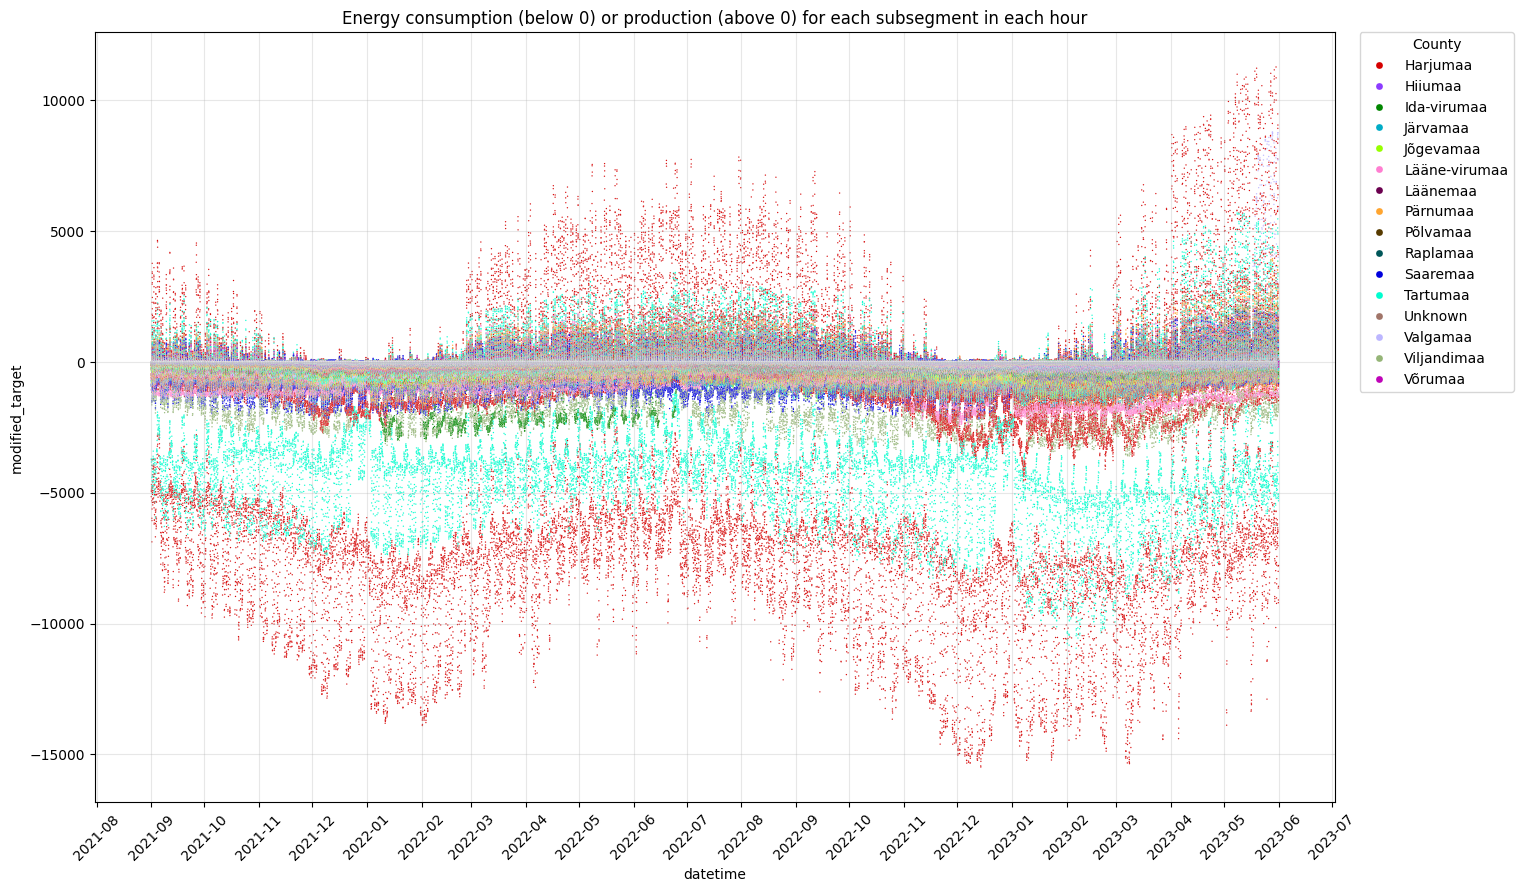

In [28]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.scatterplot(
    data=df,
    x="datetime",
    y="modified_target",
    hue="county",
    palette=PALETTE,
    s=1,
)


plt.title(
    "Energy consumption (below 0) or production (above 0) for each subsegment in each hour"
)
plt.legend(
    title="County",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0,
    markerscale=5,
)

months_locator = mdates.MonthLocator()
ax.xaxis.set_major_locator(months_locator)
plt.xticks(rotation=45)
# plt.yscale('symlog')

plt.grid(alpha=.3)
plt.show()

- ##### The higher target value, the fewer such values. With large values, it becomes easy to distinguish values by county.
- ##### Looks like both electricity consumption and production having upward trend.
- ##### Energy production in winter is significantly lower than in summer.
- ##### Energy consumption in winter is bigger than in summer.
- ##### During the New Year holidays, there is a decrease in electricity consumption.

In [29]:
# target_business = sns.relplot(
#     data=df,
#     x="datetime",
#     y="modified_target",
#     col="is_business",
#     hue="county",
#     height = 8,
#     # aspect = 1.6,
#     # size="size",
#     # style="sex",
#     palette=PALETTE,
#     s=1,
# )
# # l = target_business._legend

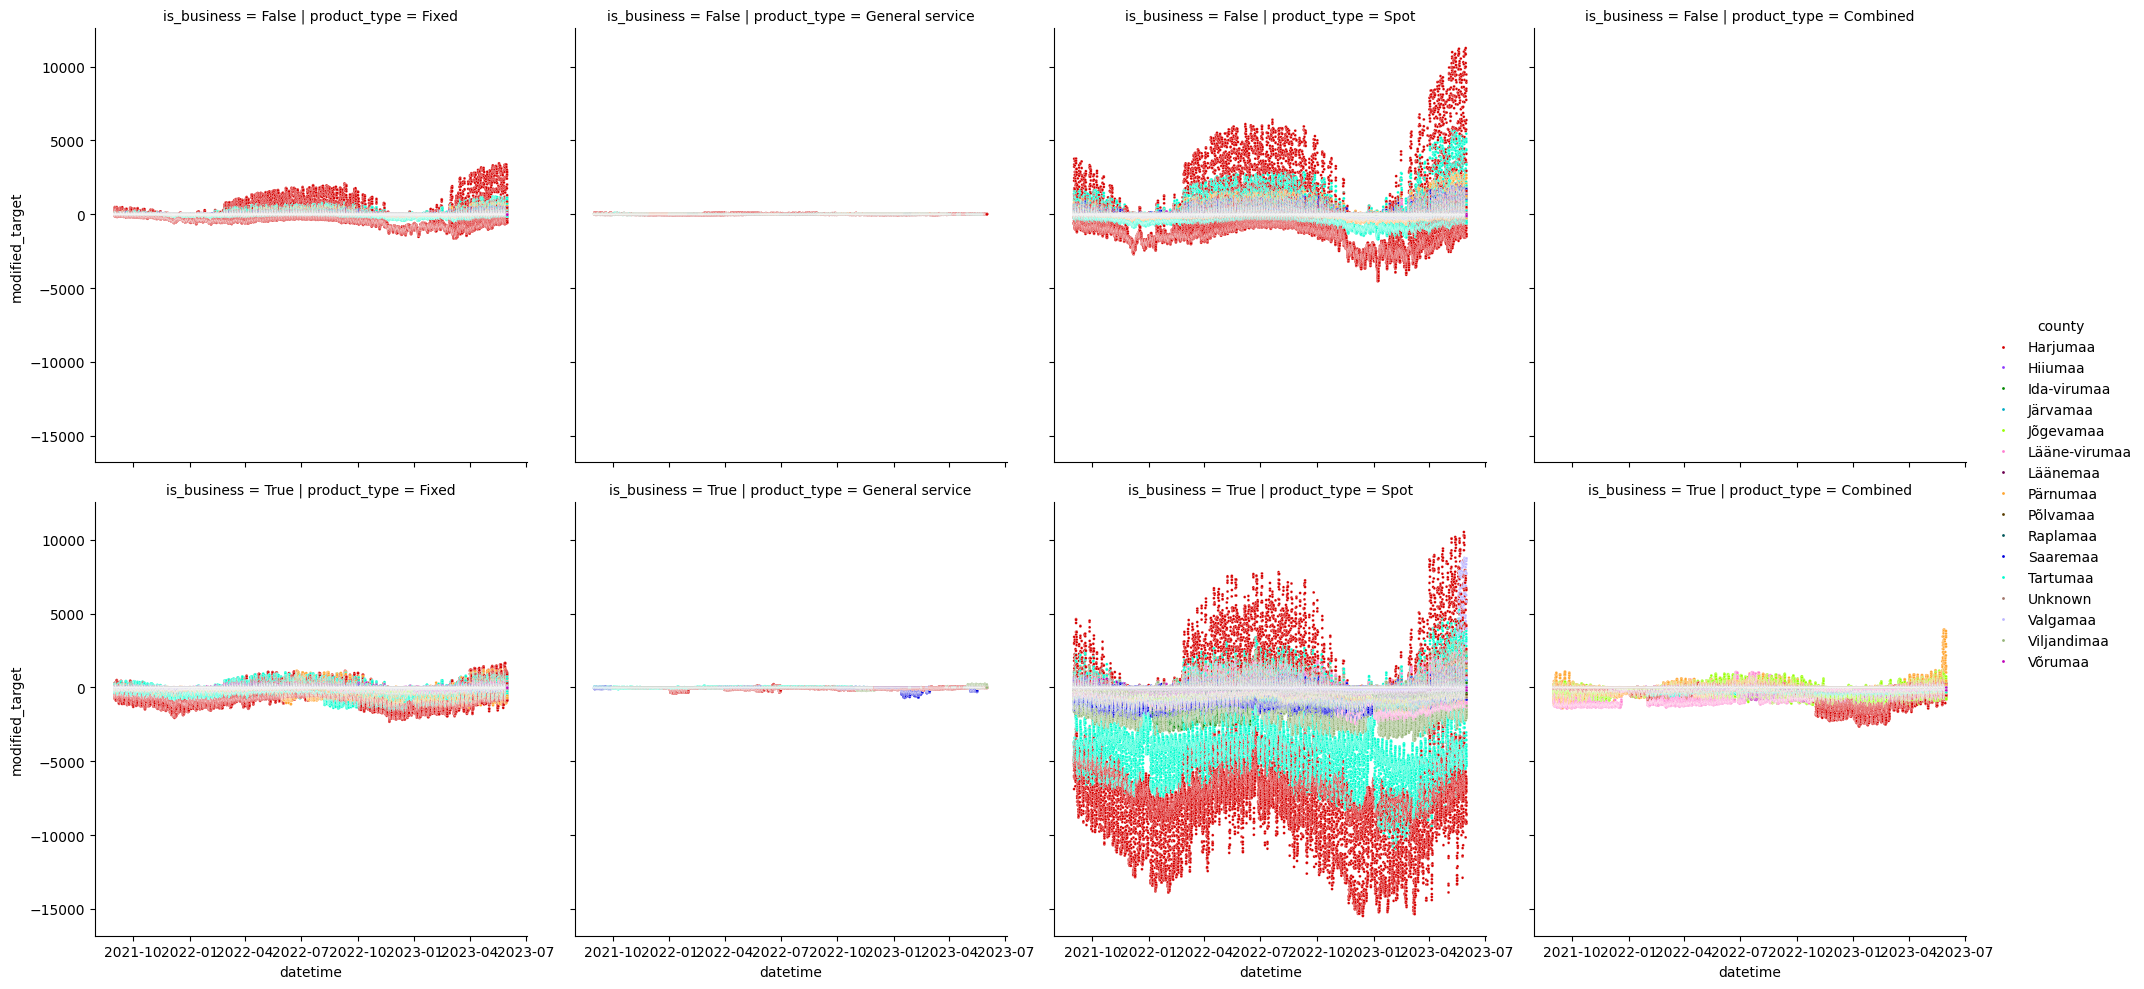

In [30]:
sns.relplot(
    data=df,
    x="datetime",
    y="modified_target",
    row='is_business',
    col="product_type",
    hue="county",
    # height = 8,
    # aspect = 1.6,
    # size="size",
    # style="sex",
    palette=PALETTE,
    s=4,
)

# conclusions from relpot

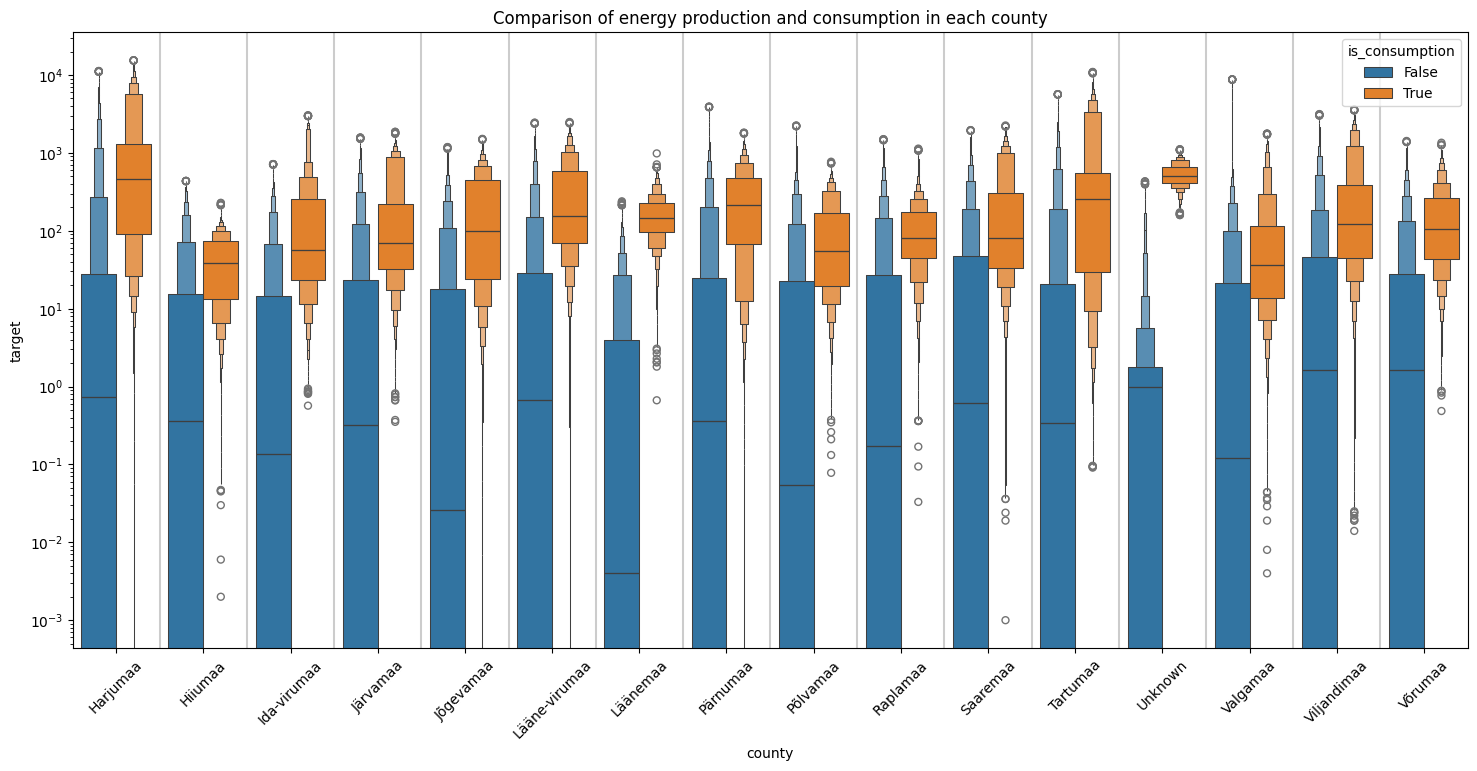

In [31]:
fig, ax = plt.subplots(figsize=(18, 8))
sns.boxenplot(
    data=df,
    x="county",
    y="target",
    hue="is_consumption",
    # k_depth = 'full'
    # split=True,
    # style='is_business',
)

plt.title(
    "Comparison of energy production and consumption in each county"
)
# plt.legend(
#     bbox_to_anchor=(1.01, 1),
#     loc="upper left",
#     borderaxespad=0,
#     # markerscale=3,
# )

for i in range(df.county.nunique()):
    ax.axvline(
        i -.5,
        color="black",
        alpha=.2
    )

plt.xticks(rotation=45)

plt.yscale('log')
# plt.grid(axis='y',alpha=.2)

plt.show()

In [33]:
df.columns

Index(['county', 'is_business', 'product_type', 'target', 'is_consumption',
       'datetime', 'data_block_id', 'row_id', 'prediction_unit_id',
       'modified_target'],
      dtype='object')

# conclusions from boxenplot

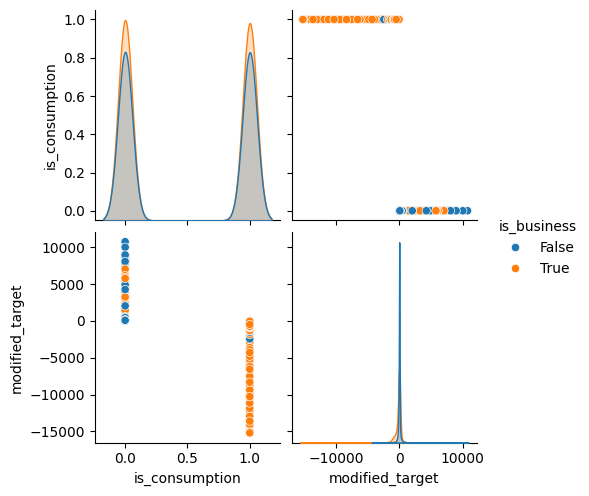

In [37]:
sns.pairplot(
    data=df.sample(100000).drop(columns=['target','data_block_id','row_id','prediction_unit_id',]),
    hue="is_business",
    # markers=["o", "s", "D"],
)

In [ ]:
# <!-- - Visualization of missing data and zeros using lineplot of the daily average

df_for_mean_day = df.copy()
df_for_mean_day['date'] = df_for_mean_day['datetime'].dt.date

fig = plt.figure(figsize=(20, 7))
ax = sns.lineplot(
    data=(df_for_mean_day
          .groupby(["date", "product_type", "county"],observed=True)["target"]
          .mean()
          .reset_index(name="target")),
    x='date',
    y='target',
    style="product_type",
    hue="county",
    ax=fig.gca(),)
ax.grid(), ax.set_yscale('log')
ax.legend(loc='center right', bbox_to_anchor=(1.15, 0.5))

In [ ]:
result = seasonal_decompose(
    x=ind.query('is_consumption == 0 and county == 0')['target'],
    model='additive',
    period=720,
)

result.plot()
plt.show()

- Visualization of seasonal_decompose

<!-- # result = seasonal_decompose(train_set, model='additive', period=12)  # Assuming seasonality is 24 hours
# trend = result.trend.dropna()
# seasonal = result.seasonal.dropna()
# residual = result.resid.dropna()

# plt.figure(figsize=(12, 8))

# plt.subplot(4, 1, 1)
# plt.plot(train_set, label='Original Series')
# plt.title('Original Series')

# plt.subplot(4, 1, 2)
# plt.plot(trend, label='Trend')
# plt.title('Trend Component')

# plt.subplot(4, 1, 3)
# plt.plot(seasonal, label='Seasonal')
# plt.title('Seasonal Component')

# plt.subplot(4, 1, 4)
# plt.plot(residual, label='Residuals')
# plt.title('Residual Component')

# plt.tight_layout()
# plt.show() -->

In [ ]:
df_for_missing = df.copy()

In [ ]:
df_for_missing['hourstamp'] = ((df_for_missing['datetime'] - df_for_missing['datetime'].min())/pd.Timedelta(hours=1)).astype(int)
df_for_missing[['hourstamp','datetime',]].max()

In [ ]:
df_for_missing['group_index'] = df_for_missing.groupby(sorted_list, observed=True).ngroup()
# df_for_missing

In [ ]:
df_for_missing['group_index'].nunique()

In [ ]:
missmap = np.empty(
    (df_for_missing.hourstamp.max() + 1, df_for_missing['group_index'].nunique(),))
missmap.fill(np.nan)

for obs in df_for_missing.values:
    missmap[int(obs[9]), (obs[10])] = 0 if obs[3]==0 else 1

In [ ]:
fig, ax = plt.subplots(figsize=(22, 80))
sns.heatmap(missmap, cmap='Paired', cbar=False)

In [ ]:
df_consumption = df.loc[df['is_consumption'] == 1].copy()
df_consumption['consumption_index'] = df_consumption.groupby(['county', 'is_business', 'product_type',], observed=True).ngroup()
df_consumption['hourstamp'] = ((df_consumption['datetime'] - df_consumption['datetime'].min())/pd.Timedelta(hours=1)).astype(int)

df_production = df.loc[df['is_consumption'] == 0].copy()
df_production['production_index'] = df_production.groupby(['county', 'is_business', 'product_type',], observed=True).ngroup()
df_production['hourstamp'] = ((df_production['datetime'] - df_production['datetime'].min())/pd.Timedelta(hours=1)).astype(int)

In [ ]:
df_consumption.columns

In [ ]:
misscon = np.empty(
    (df_consumption.hourstamp.max() + 1, df_consumption['consumption_index'].nunique(),))
misscon.fill(np.nan)

for obs in df_consumption.values:
    misscon[obs[10], obs[9]] = 0 if obs[3]==0 else 1

In [ ]:
fig, ax = plt.subplots(figsize=(22, 60))
sns.heatmap(misscon,
            cmap='Paired_r',
            # cmap=sns.diverging_palette(80, 160,),
            cbar=False)

In [ ]:
df[1_500_000:].groupby('datetime')['target'].mean().plot(figsize=(20,10))

In [ ]:
client_df = pd.read_csv("client.csv",)

In [ ]:
client_df

In [ ]:
client_df.info()

In [ ]:
client_df = client_df.astype({
    'product_type': 'category',
    'county': 'category',
    'is_business': 'category',
    'date': "datetime64[ns]",})
client_df.info()

In [ ]:
client_df.date = client_df.date.dt.date

In [ ]:
# df.date = df.datetime.dt.date

In [ ]:
sorted_list

In [ ]:
df = pd.merge(
    df,
    client_df,
    how="left",
    on=["data_block_id",
        "county",
        "is_business",
        "product_type",],
    # validate="m:1"
    # suffixes=('','current_')
)

In [ ]:
df

In [ ]:
df

In [ ]:
df.datetime + pd.Timedelta('2d')

In [ ]:
df
.eic_count.describe()

In [ ]:
df.query('county == 0 and is_business == 0 and	product_type == 1')[['target','eic_count','installed_capacity',]].plot(x='installed_capacity',y='eic_count')

In [ ]:
local_df = df.query('county == 0 and is_business == 0 and product_type == 1')
sns.lineplot(
    data = local_df[:1000][['datetime','target',]],
    x = 'datetime',
    y = 'target',)
sns.lineplot(
    data = local_df[:1000][['datetime','eic_count']],
    x = 'datetime',
    y = 'eic_count',)
# plt.show

In [ ]:
train_sg['datetime'].max().unique()

- Время последнего доступного наблюдения не одинаковое.

In [ ]:
train_sg['datetime'].diff().value_counts(dropna=False)

In [ ]:
train_dif = sorted_train.copy()
train_dif['dif'] = train_sg['datetime'].diff()

In [ ]:
train_dif.loc[train_dif['dif']=='173 days 01:00:00']

In [ ]:
added_target = sorted_train.copy()
added_target['target'] = added_target['target'] + 1e7

In [ ]:
timestamp_start = '2021-09-01'
timestamp_stop = '2022-04-10'
vis_segment = added_target.query(r"county==10 and is_business==1 and product_type==2 and is_consumption==0 and @timestamp_start <=datetime<= @timestamp_stop")

fig, ax = plt.subplots(figsize=(15, 5))
sns.scatterplot(
    data=vis_segment,
    x="datetime",
    y="target",)
# plt.xticks(range(0,vis_segment.shape[0]+1,240))
plt.show()

In [ ]:
df.query("county==0 and is_business==1 and product_type==2 and is_consumption==0 and '2021-11-15'<=datetime<='2022-03-19'")

In [ ]:
train_dif.query("county==10 and is_business==1 and product_type==2 and is_consumption==0 and 180<=data_block_id<=205")

In [ ]:
sorted_train.query('county==10 and is_business==1 and product_type==2 and is_consumption==0 and "2022-01-23" <= datetime <= "2022-04-23"')

In [ ]:
train_mm = (
    (train_sg[["datetime"]].max()) -
    (train_sg[["datetime"]].min())) / (train_sg[["datetime"]].count() - 1)

train_mm.datetime.unique()

In [ ]:
train_mm[train_mm['datetime'] == '0 days 01:03:03.867646049']

In [ ]:
sorted_df = df.sort_values(sorted_list + ['datetime'])

In [ ]:
first_df = sorted_df.query('county == 5 and is_business == 1 and product_type == 0 and is_consumption == 0').copy()

In [ ]:
first_df['datetime'].diff().unique()

In [ ]:
first_df['diff'] = first_df['datetime'].diff()
first_df = first_df.reset_index(drop=True)
first_df.loc[first_df['diff'] == '31 days 01:00:00']

In [ ]:
first_df[2926:2931]

In [ ]:
2023-05-31 23:00:00 2021-09-01

In [ ]:
2021-09-01

In [ ]:
train_mm[train_mm['datetime'] == '0 days 03:04:25.377643504']

In [ ]:
last_df = sorted_df.query('county == 14 and is_business == 1 and product_type == 2 and is_consumption == 0').copy()

In [ ]:
last_df['datetime'].diff().unique()

In [ ]:
last_df['diff'] = last_df['datetime'].diff()
last_df = last_df.reset_index(drop=True)
last_df.loc[last_df['diff'] == '76 days 01:00:00']

In [ ]:
last_df[717:724]

In [ ]:
sorted_list = ["county","is_business","product_type","is_consumption",]
test = pd.DataFrame(df
 .sort_values(by=sorted_list)
 .groupby(sorted_list)["datetime"]
 .diff())

In [ ]:
test.loc[test['datetime'] == '31 days 01:00:00']

In [ ]:
df.sort_values(by=sorted_list).loc[462816:462821]

In [ ]:
(df
 .groupby([
     "county",
     "is_business",
     "product_type",
     "is_consumption"])["datetime"].diff())

In [ ]:
(df
 .groupby([
     "county",
     "is_business",
     "product_type",
     "is_consumption"])["datetime"].count()
    - df.groupby(
        ["county", "is_business", "product_type", "is_consumption"]
    )["datetime"].nunique()
).sum()

In [ ]:
(df
 .query("'2021-10-31 02:00:00' <= datetime <= '2021-10-31 04:00:00'")
 # .sort_values(by=[
 #     "county",
 #     "is_business",
 #     "product_type",
 #     "is_consumption",
 #     "datetime",])
 .head(21))

In [ ]:
df.duplicated().sum()[df.duplicated().sum() != 0]

In [ ]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.scatterplot(
    data=df,
    x="datetime",
    y="target",
    s=1,)

plt.title(
    "Energy consumption and production")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.boxenplot(
    data=df,
    x="county",
    y="target",
    hue="is_consumption",
    # k_depth = 'full'
    # split=True,
    # style='is_business',
)

plt.title(
    "Comparison of energy production and consumption in each county"
)
# plt.legend(
#     bbox_to_anchor=(1.01, 1),
#     loc="upper left",
#     borderaxespad=0,
#     # markerscale=3,
# )
plt.yscale('log')
plt.show()

In [ ]:
sns.heatmap(
    df.drop([
        "data_block_id",
        "row_id",
        "prediction_unit_id",
        "target_modified"], axis=1)
    .corr(),
    annot=True,
    fmt=".2f",
)

plt.title('Correlation between features and target')
plt.show()

In [ ]:
# px.scatter(df[['datetime', 'modified_target', 'county']], x="datetime", y="modified_target", color='county').show()

In [ ]:
# df = df.copy().set_index("datetime")
df["hour"] = df["datetime"].dt.hour.astype("uint8")
df["day_of_week"] = df["datetime"].dt.day_of_week.astype("uint8")
df["day"] = df["datetime"].dt.day.astype("uint16")
df["week_of_year"] = (
    df["datetime"].dt.isocalendar().week.astype("int8")
)
df["month"] = df["datetime"].dt.month.astype("int8")
df["quarter"] = df["datetime"].dt.quarter.astype("int8")
df["year"] = df["datetime"].dt.year.astype("uint16")

# df["modified_target"] = np.where(
#     df["is_consumption"] == True,
#     df["target"] * (-1),
#     df["target"],
# )

df.info()

In [ ]:
sns.displot(
    data=df,
    x="target",
    hue="is_consumption",
    log_scale=True,
)

plt.title("Target's distribution")
plt.show()

In [ ]:
# target_per_county = (
#     df.groupby(["is_consumption", "county"])[["target"]]
#     .sum()
#     .groupby(level=0)
#     .apply(lambda x: x * 100 / x.sum())
#     .reset_index(level=0, drop=True)
#     .reset_index()
#     .rename(columns={"target": "percentage"})
# )
# target_per_county

In [ ]:
# plt.figure(figsize=(18,6))

# barplot = sns.barplot(
#     data=target_per_county,
#     x="county",
#     y="percentage",
#     hue="is_consumption",
# )

# for container in barplot.containers:
#     barplot.bar_label(
#         container,
#         fmt="%.2f",
#         fontsize=9,
#     )

# plt.show()

In [ ]:
def target_percentage_in_subgroup(
    df: pd.DataFrame, feature: str, broken_down_by: str, target: str
) -> pd.DataFrame:
    df = (
        df.groupby([broken_down_by, feature])[[target]]
        .sum()
        .groupby(level=0)
        .apply(lambda x: x * 100 / x.sum())
        .reset_index(level=0, drop=True)
        .reset_index()
        .rename(columns={"target": "percentage"})
    )
    return df

In [ ]:
def plot_for_categorical_feature(
    df: pd.DataFrame,
    broken_down_by: str,
    features_list: list[str],
    target: str,
):
    length = len(features_list)
    fig, axs = plt.subplots(
        nrows=length,
        ncols=1,
        figsize=(18, 15),
    )
    fig.tight_layout(pad=5)

    for idx, feature in enumerate(features_list):
        plt.subplot(length, 1, 1 + idx)
        data = target_percentage_in_subgroup(
            df, feature, broken_down_by, target
        )

        barplot = sns.barplot(
            data=data,
            x=feature,
            y="percentage",
            hue=broken_down_by,
        )

        for container in barplot.containers:
            barplot.bar_label(
                container,
                fmt="%.2f",
            )

        plt.title(f"{feature} broken down by {broken_down_by}")
    plt.show()

In [ ]:
plot_for_categorical_feature(
    df,
    "is_consumption",
    ["county", "is_business", "product_type"],
    "target",
)

In [ ]:
# sns.relplot(
#     data=df.loc[df['county'] == 2][["datetime", "target", "is_consumption",'is_business']],
#     x="datetime",
#     y="target",
#     col="is_consumption",
#     height=5,
#     aspect=1.5,
#     hue="is_business",
#     # size="size",
#     # style="sex",
#     # palette=["b", "r"],
#     # sizes=(10, 100),
# )

In [ ]:
fig, ax = plt.subplots(figsize=(10, 2))
length = 24

sns.lineplot(
    data=[np.sin((2 * i * np.pi / (length))) for i in range(length)],
)
sns.lineplot(
    data=[np.cos(i / (length / 2 / np.pi)) for i in range(length)],
)
# sns.lineplot(
#     data=[np.sin((i * np.pi / 7)) for i in range(length)],
# )
# sns.lineplot(
#     data=[np.tan((i / (len / np.pi)) + np.pi/2 + np.pi/len) for i in range(len)],
# )

# plt.xticks(range(-1, 25))
# plt.yscale('symlog')
plt.grid()
plt.show()

In [ ]:
length = 24
for idx, i in enumerate(zip([round(np.sin((2 * i * np.pi / (length))), 3) for i in range(length)], [round(np.cos((2 * i * np.pi / (length))), 3) for i in range(length)])):
    print(idx, i)

In [ ]:
length = 365
[np.tan((i / (length / np.pi)) + np.pi/2) for i in range(length)]

In [ ]:
list_of_sins = [np.sin(i / (len / 2 / np.pi)) for i in range(len)]
list_of_cos = [np.cos(i / (len / 2 / np.pi)) for i in range(len)]
list_of_tans = [(np.sin(i / (len / 2 / np.pi)))/(np.cos(i / (len / 2 / np.pi)))for i in range(len)]
for i in zip(list_of_sins, list_of_cos, list_of_tans):
    print(i)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 2))
# len = 10
sns.lineplot(
    data=hours_list,
    # x="datetime",
    # y="target",
    # s=1,
    # hue="county",
    # style='is_business',
)
# ax.set(title = 'Energy consumption or production for the discrete segment for the hour')
plt.grid()
plt.show()

In [ ]:
# df['hr_sin'] = np.sin(df.hr*(2.*np.pi/24))
# df['hr_cos'] = np.cos(df.hr*(2.*np.pi/24))
# df['mnth_sin'] = np.sin((df.mnth-1)*(2.*np.pi/12))
# df['mnth_cos'] = np.cos((df.mnth-1)*(2.*np.pi/12))

In [ ]:
df.groupby("is_consumption")["target"].min()

In [ ]:
df.isna().sum()[df.isna().sum() != 0]

In [ ]:
df.duplicated().sum()[df.duplicated().sum() != 0]

In [ ]:
df.loc[df.isna().any(axis=1)]

In [ ]:
df.datetime[0]

In [ ]:
train = (train
         .astype({
             "county": "category",
             "is_business": "category",
             "product_type": "category",
             "is_consumption": "category",
             "datetime": "datetime64[ns]",})
         .sort_values(by=[
             "county",
             "is_business",
             "product_type",
             "is_consumption",
             "datetime"]))

In [ ]:
(
    df.query(
        "'2021-10-31 02:00:00' <= datetime <= '2021-10-31 04:00:00'"
    )
    .sort_values(
        by=[
            "county",
            "is_business",
            "product_type",
            "is_consumption",
            "datetime",
        ]
    )
    .head(21)
)

In [ ]:
[df[df.isna().any(axis=1)].datetime.unique()]

In [ ]:
df = df.sort_values(
    by=["county", "is_business", "product_type", "is_consumption", "datetime"]
).interpolate()

In [ ]:
(
    df.query(
        "'2021-10-31 02:00:00' <= datetime <= '2021-10-31 04:00:00'"
    ).head(21)
)

In [ ]:
sns.displot(
    data=df[["target"]],
    log_scale=True,
)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.scatterplot(
    data=df,
    x="datetime",
    y="target",
    # hue="county",
    # style='is_business',
    # log_scale=True,
)
plt.show()

In [ ]:
sns.displot(
    data=df[["target", "is_business", "product_type"]],
    x="target",
    # bins=200,
    element="poly",
    hue="is_business",
    col="product_type",
    log_scale=True,
)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(df.corr(), annot=True, cmap="Blues", fmt=".2f")
plt.show()

In [ ]:
sns.relplot(
    data=df.query("county == 0 and is_business == False"),
    x="datetime",
    y="target",
    col="product_type",
    hue="is_consumption",
)
plt.yscale("log")

In [ ]:
sns.relplot(
    data=df.query("county == 0 and is_business == True"),
    x="datetime",
    y="target",
    col="product_type",
    hue="is_consumption",
)
plt.yscale("log")

In [ ]:
sns.scatterplot(
    data=df.query("county==0 and is_business == True"),
    x="datetime",
    y="target",
    hue="is_consumption",
)

In [ ]:
sns.scatterplot(
    data=df.query("is_business == True and is_consumption == False"),
    x="datetime",
    y="target",
    hue="county",
)

# 3. Feature Engineering

In [ ]:
df = df.copy().set_index("datetime")
df

In [ ]:
df["hour"] = df.index.hour.astype("uint8")
df["day_of_week"] = df.index.day_of_week.astype("uint8")
df["day"] = df.index.day.astype("uint16")
df["week_of_year"] = df.index.isocalendar().week.astype("int8")
df["month"] = df.index.month.astype("int8")
df["quarter"] = df.index.quarter.astype("int8")
df["year"] = df.index.year.astype("uint16")

df["modified_target"] = np.where(
    df["is_consumption"] == True, df["target"] * (-1), df["target"]
)

df.info()

In [ ]:
fig, ax = plt.subplots(figsize=(25, 8))
sns.scatterplot(
    data=df,
    x="datetime",
    y="modified_target",
    # hue="county",
    # style='is_business',
    # log_scale=True,
)
plt.show()

In [ ]:
sns.displot(
    data=df[["modified_target"]],
    x="modified_target",
    log_scale=True,
)

In [ ]:
sns.relplot(
    data=df.query("county == 0")[
        ["modified_target", "product_type", "is_consumption", "is_business"]
    ],
    x="datetime",
    y="modified_target",
    col="product_type",
    hue="is_business",
    # size="size",
    # style="sex",
    # palette=["b", "r"],
    # sizes=(10, 100),
)
# plt.axhline(y = 10,
#             color = 'r',
#             linestyle = '-',
#            lw=100,)
# plt.xscale('log')
plt.yscale("log")
plt.show()

In [ ]:
df.columns

In [ ]:
sns.scatterplot(
    data=df.query("county == 4 and product_type == 1 and is_business == 1")[
        [
            "modified_target",
            "product_type",
            "is_consumption",
            "is_business",
        ]
    ],
    x="datetime",
    y="modified_target",
)
plt.show()

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 8))

# sns.heatmap(df.corr(), annot=True, cmap="Blues", fmt=".2f")
# # plt.figure(figsize=(25, 25))
# plt.show()
# # numeric_only=True

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))

sns.scatterplot(
    data=df.query(
        "'2023-01-1 8:00:00' <= datetime <= '2023-01-28 23:00:00' and \
        product_type == 3"
    )[
        [
            "county",
            "modified_target",
            "product_type",
            "is_consumption",
            "is_business",
        ]
    ],
    x="datetime",
    y="modified_target",
    # col = 'product_type',
    # product_type
    style="is_business",
    hue="is_business",
    # aspect = 3,
    # # height = 5,
    alpha=0.5,
)
plt.show()

# county
# is_business
# product_type
# is_consumption

In [ ]:
hours_ago = (
    [i for i in range(1, 25)]
    + [24 * i for i in range(2, 8)]
    + [168 * i for i in range(2, 9)]
    + [672 * i for i in range(3, 13)]
)
for h in hours_ago:
    df_hours[f"tm_{h}h"] = df_hours["modified_target"].shift(h)
df_hours.info()

In [ ]:
for h in i in range(24):
    df[f"tm_{i}h"] = df["modified_target"].shift(i)
df["tm_1h"] = df["modified_target"].shift(1)

In [ ]:
df.shift(periods=1)

In [ ]:
# def add_lags(df):
#     target_map = df['PJME_MW'].to_dict()
#     df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
#     df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
#     df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
#     return df

In [ ]:
df_label = df.astype(
    {
        "county": "category",
        "is_business": "category",
        "product_type": "category",
        "is_consumption": "category",
    }
)
df_label.info()

In [ ]:
df_label = pd.get_dummies(df_label, drop_first=True)
df_label.info()

In [ ]:
df_label.columns

In [ ]:
X = df_label.drop(
    columns=[
        "target",
        "data_block_id",
        "row_id",
        "prediction_unit_id",
        "modified_target",
    ],
    axis=1,
)

y = df_label["modified_target"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RAND
)

st = StandardScaler()
X_train_std = st.fit_transform(X_train)
X_test_std = st.transform(X_test)

In [ ]:
def r2_adjusted(
    y_true: np.ndarray, y_pred: np.ndarray, X_test: np.ndarray | int
) -> float:
    """Коэффициент детерминации (множественная регрессия)"""
    N_objects = len(y_true)

    if isinstance(X_test, np.ndarray):
        N_features = X_test.shape[1]
    else:
        N_features = X_test

    #     N_features = X_test.shape[1]
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (N_objects - 1) / (N_objects - N_features - 1)


def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean percentage error"""
    return np.mean((y_true - y_pred) / y_true, axis=0) * 100


def mape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean absolute percentage error"""
    return np.mean(np.abs((y_pred - y_true) / y_true), axis=0) * 100


def wape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Weighted Absolute Percent Error"""
    return np.sum(np.abs(y_pred - y_true)) / np.sum(y_true) * 100


def huber_loss(
    y_true: np.ndarray | pd.DataFrame,
    y_pred: np.ndarray | pd.DataFrame,
    delta: float = 1.345,
):
    """Функция ошибки Хьюбера"""

    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.squeeze().to_numpy()
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.squeeze().to_numpy()

    assert len(y_true) == len(y_pred), "Разные размеры данных"
    huber_sum = 0
    for i in range(len(y_true)):
        if abs(y_true[i] - y_pred[i]) <= delta:
            huber_sum += 0.5 * (y_true[i] - y_pred[i]) ** 2
        else:
            huber_sum += delta * (abs(y_true[i] - y_pred[i]) - 0.5 * delta)
    huber_sum /= len(y_true)
    return huber_sum


def logcosh(y_true: np.ndarray, y_pred: np.ndarray):
    """функция ошибки Лог-Кош"""
    return np.sum(np.log(np.cosh(y_true - y_pred)))


def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    """
    Root Mean Squared Log Error (RMSLE) metric
    Логарифмическая ошибка средней квадратичной ошибки
    """
    try:
        return np.sqrt(mean_squared_log_error(y_true, y_pred))
    except:
        return None


def get_metrics(
    y_test: np.ndarray,
    y_pred: np.ndarray,
    X_test: np.ndarray,
    name: str = None,
    delta: float = 1.345,
):
    """Генерация таблицы с метриками"""
    df_metrics = pd.DataFrame()
    df_metrics["model"] = [name]

    df_metrics["MAE"] = mean_absolute_error(y_test, y_pred)
    df_metrics["MSE"] = mean_squared_error(y_test, y_pred)
    df_metrics["Huber_loss"] = huber_loss(y_test, y_pred, delta)
    df_metrics["Logcosh"] = logcosh(y_test, y_pred)
    df_metrics["RMSE"] = np.sqrt(mean_squared_error(y_test, y_pred))
    df_metrics["RMSLE"] = rmsle(y_test, y_pred)
    df_metrics["R2 adjusted"] = r2_adjusted(y_test, y_pred, X_test)
    df_metrics["MPE_%"] = mpe(y_test, y_pred)
    df_metrics["MAPE_%"] = mape(y_test, y_pred)
    df_metrics["WAPE_%"] = wape(y_test, y_pred)

    return df_metrics

In [ ]:
lr_skl = LinearRegression()
lr_skl.fit(X_train_std, y_train)

In [ ]:
lr_skl_pred = lr_skl.predict(X_test_std)

In [ ]:
skl_m = get_metrics(y_test, lr_skl_pred, X_test_std, name="skl_lr")
skl_m

In [ ]:
df_hours = df_hours[
    [
        "county",
        "is_business",
        "product_type",
        "target",
        "is_consumption",
        "hour",
        "day_of_week",
        "day",
        "week_of_year",
        "month",
        "quarter",
        "year",
        "modified_target",
        "tm_1h",
        "tm_2h",
        "tm_3h",
        "tm_4h",
        "tm_5h",
        "tm_6h",
        "tm_7h",
        "tm_8h",
        "tm_9h",
        "tm_10h",
        "tm_11h",
        "tm_12h",
        "tm_13h",
        "tm_14h",
        "tm_15h",
        "tm_16h",
        "tm_17h",
        "tm_18h",
        "tm_19h",
        "tm_20h",
        "tm_21h",
        "tm_22h",
        "tm_23h",
        "tm_24h",
        "tm_48h",
        "tm_72h",
        "tm_96h",
        "tm_120h",
        "tm_144h",
        "tm_168h",
        "tm_336h",
        "tm_504h",
        "tm_672h",
        "tm_840h",
        "tm_1008h",
        "tm_1176h",
        "tm_1344h",
        "tm_2016h",
        "tm_2688h",
        "tm_3360h",
        "tm_4032h",
        "tm_4704h",
        "tm_5376h",
        "tm_6048h",
        "tm_6720h",
        "tm_7392h",
        "tm_8064h",
    ]
]

In [ ]:
df_hours = df_hours.sort_index()
tss = TimeSeriesSplit(n_splits=3, test_size=300_000)

In [ ]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df_hours):
    train = df_hours.iloc[train_idx]
    test = df_hours.iloc[val_idx]

    reg = XGBRegressor(
        n_estimators=2000,
        early_stopping_rounds=50,
        objective="reg:squarederror",
        enable_categorical=True,
        eval_metric="mae",
        # max_depth=3,
        learning_rate=0.01,
        random_state=RAND,
    )
    FEATURES = [
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "hour",
        "day_of_week",
        "day",
        "week_of_year",
        "month",
        "quarter",
        "year",
        "tm_1h",
        "tm_2h",
        "tm_3h",
        "tm_4h",
        "tm_5h",
        "tm_6h",
        "tm_7h",
        "tm_8h",
        "tm_9h",
        "tm_10h",
        "tm_11h",
        "tm_12h",
        "tm_13h",
        "tm_14h",
        "tm_15h",
        "tm_16h",
        "tm_17h",
        "tm_18h",
        "tm_19h",
        "tm_20h",
        "tm_21h",
        "tm_22h",
        "tm_23h",
        "tm_24h",
        "tm_48h",
        "tm_72h",
        "tm_96h",
        "tm_120h",
        "tm_144h",
        "tm_168h",
        "tm_336h",
        "tm_504h",
        "tm_672h",
        "tm_840h",
        "tm_1008h",
        "tm_1176h",
        "tm_1344h",
        "tm_2016h",
        "tm_2688h",
        "tm_3360h",
        "tm_4032h",
        "tm_4704h",
        "tm_5376h",
        "tm_6048h",
        "tm_6720h",
        "tm_7392h",
        "tm_8064h",
    ]
    # TARGET = "modified_target"
    TARGET = "target"

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=20,
    )

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

In [ ]:
hours_ago = (
    [i for i in range(1, 25)]
    + [24 * i for i in range(2, 8)]
    + [168 * i for i in range(2, 9)]
    + [672 * i for i in range(3, 13)]
)
for h in hours_ago:
    df[f"t_{h}h"] = df["target"].shift(h)

In [ ]:
fig, ax = plt.subplots(figsize=(35, 30))

sns.heatmap(df_hours.corr(), annot=True, cmap="Blues", fmt=".1f")
# plt.figure(figsize=(25, 25))
plt.show()
# numeric_only=True

In [ ]:
# df = df.sort_index().sort_values(
#     ["county", "is_business", "product_type", "is_consumption"],
#     kind="mergesort",
# )
df.sort_index()
tss = TimeSeriesSplit(n_splits=3, test_size=300_000)

In [ ]:
# for train_idx, val_idx in tss.split(df):
# print('1 train:', train_idx)
# display(df.iloc[train_idx].tail(5))
# print('1 val:', val_idx)

In [ ]:
tss = TimeSeriesSplit(n_splits=3, test_size=300_000)
df = df.sort_index()

fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
fold = 0

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train["modified_target"].plot(
        ax=axs[fold],
        label="Training Set",
        title=f"Data Train/Test Split Fold {fold}",
    )
    test["modified_target"].plot(ax=axs[fold], label="Test Set")
    axs[fold].axvline(test.index.min(), color="black", ls="--")
    fold += 1
plt.show()

In [ ]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    reg = XGBRegressor(
        n_estimators=2000,
        early_stopping_rounds=50,
        objective="reg:squarederror",
        enable_categorical=True,
        eval_metric="mae",
        # max_depth=3,
        learning_rate=0.01,
        random_state=RAND,
    )
    FEATURES = [
        "county",
        "is_business",
        "product_type",
        # 'target',
        "is_consumption",
        # 'data_block_id',
        # 'row_id',
        # 'prediction_unit_id',
        "hour",
        "day_of_week",
        "day",
        "week_of_year",
        "month",
        "quarter",
        "year",
        # 'modified_target',
    ]
    TARGET = "modified_target"

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=20,
    )

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

- **county - An ID code for the county.**
- **is_business - Boolean for whether or not the prosumer is a business.**
- **product_type - ID code with the following mapping of codes to contract - types: {0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}.**
- **target - The consumption or production amount for the relevant segment for the hour. The segments are defined by the county, is_business, and product_type.**
- **is_consumption - Boolean for whether or not this row's target is consumption or production.**
- **datetime - The Estonian time in EET (UTC+2) / EEST (UTC+3).**
- **data_block_id - All rows sharing the same data_block_id will be available at the same forecast time. This is a function of what information is available when forecasts are actually made, at 11 AM each morning. For example, if the forecast weather data_block_id for predictins made on October 31st is 100 then the historic weather data_block_id for October 31st will be 101 as the historic weather data is only actually available the next day.**
- **row_id - A unique identifier for the row.**
- **prediction_unit_id - A unique identifier for the county, is_business, and product_type combination. New prediction units can appear or disappear in the test set.**